### Load Packages

In [60]:
# imports
import os
import seaborn as sns
from scipy import stats
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline


import nltk
nltk.download('stopwords')
from nltk import word_tokenize
nltk.download('punkt')


import re
import string

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')


import lightgbm as lgb
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_columns = 100
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read the datasets

In [61]:
glove_file = 'F:\\MachineHack\\identify_author\\glove.6B\\'

glove_file_1 =  'F:\\MachineHack\\identify_author\\glove.840B.300d\\'

In [62]:
sub_df = pd.read_excel('Sample_Submission.xlsx')

In [63]:
sub_df.head(3)

,Price
0,119
1,123
2,108


In [64]:
sub_df.shape

(1560, 1)

In [65]:
train_df = pd.read_excel('Data_Train.xlsx', encoding='latin-1')

In [66]:
train_df.head(3)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00


In [67]:
train_df['Edition'].value_counts().head()

Paperback,– 5 Oct 2017    48
Paperback,– 2016          46
Paperback,– 2017          36
Paperback,– 2013          31
Paperback,– 2019          30
Name: Edition, dtype: int64

In [68]:
test_df = pd.read_excel('Data_Test.xlsx', encoding='latin-1')

In [69]:
test_df.head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"


In [70]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 6237
Number of columns in train: 9


In [71]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 1560
Number of columns in test: 8


In [72]:
print(train_df.shape)
print(test_df.shape)

(6237, 9)
(1560, 8)


In [73]:
train_df.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price'],
      dtype='object')

### WordClouds

In [74]:
from wordcloud import WordCloud, STOPWORDS

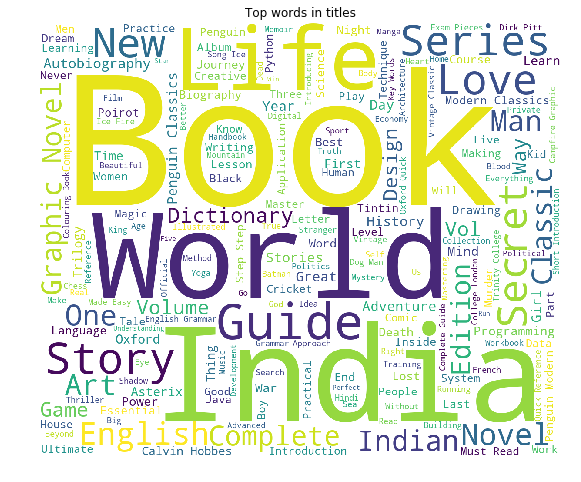

In [75]:
plt.figure(figsize = (12, 8))
text = ' '.join(train_df['Title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [76]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

train_df['Synopsis'] = train_df['Synopsis'].apply(clean_text)
test_df['Synopsis'] = test_df['Synopsis'].apply(clean_text)

In [77]:
## Number of words in the Synopsis ##
train_df["Syn_num_words"] = train_df["Synopsis"].apply(lambda x: len(str(x).split()))
test_df["Syn_num_words"] = test_df["Synopsis"].apply(lambda x: len(str(x).split()))

## Number of unique words in the Synopsis ##
train_df["Syn_num_unique_words"] = train_df["Synopsis"].apply(lambda x: len(set(str(x).split())))
test_df["Syn_num_unique_words"] = test_df["Synopsis"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the Synopsis ##
train_df["Syn_num_chars"] = train_df["Synopsis"].apply(lambda x: len(str(x)))
test_df["Syn_num_chars"] = test_df["Synopsis"].apply(lambda x: len(str(x)))

## Number of stopwords in the Synopsis ##
train_df["Syn_num_stopwords"] = train_df["Synopsis"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["Syn_num_stopwords"] = test_df["Synopsis"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the Synopsis ##
train_df["Syn_num_punctuations"] =train_df['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["Syn_num_punctuations"] =test_df['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the Synopsis ##
train_df["Syn_num_words_upper"] = train_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["Syn_num_words_upper"] = test_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the Synopsis ##
train_df["Syn_num_words_title"] = train_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["Syn_num_words_title"] = test_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the Synopsis ##
train_df["mean_word_len"] = train_df["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [78]:
## Number of words in the Title ##
train_df["Tit_num_words"] = train_df["Title"].apply(lambda x: len(str(x).split()))
test_df["Tit_num_words"] = test_df["Title"].apply(lambda x: len(str(x).split()))

## Number of unique words in the Title ##
train_df["Tit_num_unique_words"] = train_df["Title"].apply(lambda x: len(set(str(x).split())))
test_df["Tit_num_unique_words"] = test_df["Title"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the Title ##
train_df["Tit_num_chars"] = train_df["Title"].apply(lambda x: len(str(x)))
test_df["Tit_num_chars"] = test_df["Title"].apply(lambda x: len(str(x)))

## Number of stopwords in the Title ##
train_df["Tit_num_stopwords"] = train_df["Title"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["Tit_num_stopwords"] = test_df["Title"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the Title ##
train_df["Tit_num_punctuations"] =train_df['Title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["Tit_num_punctuations"] =test_df['Title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the Title ##
train_df["Tit_num_words_upper"] = train_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["Tit_num_words_upper"] = test_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the Title ##
train_df["Tit_num_words_title"] = train_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["Tit_num_words_title"] = test_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the Title ##
train_df["mean_word_len"] = train_df["Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [79]:
# * join the datasets
train_df['is_train']  = 1
test_df['Price'] = 0
test_df['is_train'] = 0

In [80]:
full_df = train_df.append(test_df)

In [81]:
full_df.head()

,Author,BookCategory,Edition,Genre,Price,Ratings,Reviews,Syn_num_chars,Syn_num_punctuations,Syn_num_stopwords,Syn_num_unique_words,Syn_num_words,Syn_num_words_title,Syn_num_words_upper,Synopsis,Tit_num_chars,Tit_num_punctuations,Tit_num_stopwords,Tit_num_unique_words,Tit_num_words,Tit_num_words_title,Tit_num_words_upper,Title,is_train,mean_word_len
0,Chris Kuzneski,Action & Adventure,"Paperback,– 10 Mar 2016",Action & Adventure (Books),220.00,8 customer reviews,4.0 out of 5 stars,705,0,37,87,112,0,0,the hunters return their third brilliant novel...,35,3,1,6,6,4,0,The Prisoner's Gold (The Hunters 3),1,5.000000
1,Arun Khopkar,"Biographies, Diaries & True Accounts","Paperback,– 7 Nov 2012",Cinema & Broadcast (Books),202.93,14 customer reviews,3.9 out of 5 stars,1032,0,40,110,159,0,0,layered portrait troubled genius for whom art ...,34,1,2,7,7,6,1,Guru Dutt: A Tragedy in Three Acts,1,4.000000
2,Thomas Hobbes,Humour,"Paperback,– 25 Feb 1982",International Relations,299.00,6 customer reviews,4.8 out of 5 stars,1482,0,66,157,211,0,0,during the time men live without common power ...,28,2,0,3,3,3,0,Leviathan (Penguin Classics),1,8.666667
3,Agatha Christie,"Crime, Thriller & Mystery","Paperback,– 5 Oct 2017",Contemporary Fiction (Books),180.00,13 customer reviews,4.1 out of 5 stars,353,0,16,47,54,0,0,handful grain found the pocket murdered busine...,34,2,2,7,7,6,1,A Pocket Full of Rye (Miss Marple),1,4.000000
4,Editors of Life,"Arts, Film & Photography","Hardcover,– 10 Oct 2006",Photography Textbooks,965.62,1 customer review,5.0 out of 5 stars,586,0,33,66,88,0,0,for seven decades life has been thrilling the ...,42,0,1,6,6,3,1,LIFE 70 Years of Extraordinary Photography,1,6.166667


In [82]:
full_df[['Edition_Type','Date']] = full_df.Edition.astype(str).str.split(",–", n = 1, expand = True)


In [83]:
full_df['Year'] = full_df['Date'].apply(lambda x: x[-5:] if x[-1].isdigit() else np.nan)

In [84]:
full_df['Reviews'] = full_df['Reviews'].apply(lambda x: x.replace('out of 5 stars', ''))
full_df['Ratings'] = full_df['Ratings'].apply(lambda x: x.replace('customer reviews', ''))
full_df['Ratings'] = full_df['Ratings'].apply(lambda x: x.replace('customer review', ''))

In [85]:
full_df['Date'].head()

0     10 Mar 2016
1      7 Nov 2012
2     25 Feb 1982
3      5 Oct 2017
4     10 Oct 2006
Name: Date, dtype: object

In [86]:
# code to find characters in string 
def find_chars(x):
  if(len(str(x))>0):
    return " ".join(re.split("[^a-zA-Z]*", x))
  else:
    return ""  

full_df['Month'] = full_df['Date'].apply(lambda x: find_chars(x))

def last_3_chars(x):
  if (len(x)>0):
    x = ''.join(x.split())
    return x[-3:]
  else:
    return ''  


full_df['Month'] = full_df['Month'].apply(lambda x: last_3_chars(x))
full_df['Month'].value_counts()

Oct    795
Sep    696
May    668
Jan    637
Nov    625
Apr    605
Jun    605
Jul    580
Mar    574
Aug    544
Feb    508
Dec    503
       418
ort     15
set      7
ted      6
int      5
ion      2
ile      1
ook      1
TSC      1
ged      1
Name: Month, dtype: int64

In [87]:
def is_Paperback(x):
  if (str(x).find('Paperback') >-1):
    return 'Paperback'
  elif (str(x).find('Hardcover') >-1):
    return 'Hardcover'
  else:
    return 'Other'

In [88]:
full_df['Edition_Type'] = full_df['Edition_Type'].apply(lambda x: is_Paperback(x))

In [89]:
full_df['Edition_Type'].value_counts()

Paperback    6664
Hardcover    1056
Other          77
Name: Edition_Type, dtype: int64

In [90]:
testcount = len(test_df)
count = len(full_df)-testcount
print(count)

6237


In [91]:
print(full_df.shape)

(7797, 29)


In [92]:
dfDummies = pd.get_dummies(full_df['BookCategory'], prefix = 'BookCategory')
full_df = pd.concat([full_df, dfDummies], axis=1)

dfDummies = pd.get_dummies(full_df['Edition_Type'], prefix = 'Edition_Type')
full_df = pd.concat([full_df, dfDummies], axis=1)


dfDummies = pd.get_dummies(full_df['Month'], prefix = 'Month')
full_df = pd.concat([full_df, dfDummies], axis=1)

In [93]:
# FinalData= FinalData.drop(cols,axis=1)
train = full_df[:count]
test = full_df[count:]
print(train.shape, test.shape)


train_df = train.copy()
test_df = test.copy()

(6237, 65) (1560, 65)


In [94]:
import re

trim_function = lambda x : re.findall("^\s*(.*?)\s*$",str(x))[0]

remove_commas = lambda x: re.sub("[^\d]", "", str(x))


train_df['Ratings']= train_df['Ratings'].apply(trim_function).apply(remove_commas).astype(int)
test_df['Ratings']= test_df['Ratings'].apply(trim_function).apply(remove_commas).astype(int)

train_df['Reviews']= train_df['Reviews'].apply(trim_function).apply(remove_commas).astype(int)
test_df['Reviews']= test_df['Reviews'].apply(trim_function).apply(remove_commas).astype(int)

In [95]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4),max_features=200)
full_tfidf = tfidf_vec.fit_transform(train_df['Synopsis'].values.tolist() + test_df['Synopsis'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Synopsis'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Synopsis'].values.tolist())

In [96]:
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

In [97]:
test_df.shape

(1560, 265)

In [98]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4),max_features=150)
full_tfidf = tfidf_vec.fit_transform(train_df['Title'].values.tolist() + test_df['Title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Title'].values.tolist())

In [99]:
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

In [100]:
### Fit transform the CountVectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char', max_features=100)
tfidf_vec.fit(train_df['Title'].values.tolist() + test_df['Title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Title'].values.tolist())


train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

In [101]:
### Fit transform the CountVectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char', max_features=100)
tfidf_vec.fit(train_df['Synopsis'].values.tolist() + test_df['Synopsis'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Synopsis'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Synopsis'].values.tolist())


train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

### Glove Vectors

In [102]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open(glove_file_1+'glove.840B.300d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


0it [00:00, ?it/s]
1it [00:00,  3.50it/s]
319it [00:00,  5.00it/s]
762it [00:00,  7.13it/s]
1226it [00:00, 10.18it/s]
1690it [00:00, 14.53it/s]
2077it [00:00, 20.73it/s]
2545it [00:00, 29.56it/s]
2980it [00:01, 42.10it/s]
3446it [00:01, 59.90it/s]
3890it [00:01, 85.08it/s]
4326it [00:01, 120.51it/s]
4748it [00:01, 170.01it/s]
5244it [00:01, 239.32it/s]
5685it [00:01, 333.11it/s]
6179it [00:01, 462.50it/s]
6667it [00:01, 634.30it/s]
7122it [00:01, 845.84it/s]
7555it [00:02, 1107.73it/s]
7978it [00:02, 1373.60it/s]
8427it [00:02, 1734.63it/s]
8839it [00:02, 2098.12it/s]
9343it [00:02, 2542.53it/s]
9780it [00:02, 2861.80it/s]
10228it [00:02, 3203.71it/s]
10700it [00:02, 3537.47it/s]
11143it [00:02, 3732.12it/s]
11582it [00:03, 3597.12it/s]
11990it [00:03, 3720.98it/s]
12396it [00:03, 3225.04it/s]
12808it [00:03, 3444.60it/s]
13255it [00:03, 3681.36it/s]
13648it [00:03, 3724.42it/s]
14092it [00:03, 3912.00it/s]
14538it [00:03, 4047.94it/s]
15031it [00:03, 4237.14it/s]
15547it [00:04, 4447

113619it [00:31, 3069.83it/s]
113970it [00:31, 3044.56it/s]
114306it [00:32, 2866.65it/s]
114739it [00:32, 3183.60it/s]
115101it [00:32, 3282.33it/s]
115587it [00:32, 3624.08it/s]
115975it [00:32, 3420.48it/s]
116337it [00:32, 3317.77it/s]
116751it [00:32, 3519.24it/s]
117117it [00:32, 3355.88it/s]
117464it [00:32, 3343.64it/s]
117807it [00:33, 3184.07it/s]
118175it [00:33, 3309.99it/s]
118552it [00:33, 3433.82it/s]
118952it [00:33, 3583.08it/s]
119316it [00:33, 3436.51it/s]
119678it [00:33, 3467.19it/s]
120112it [00:33, 3681.28it/s]
120487it [00:33, 3691.45it/s]
120861it [00:33, 3577.99it/s]
121223it [00:34, 3184.61it/s]
121553it [00:34, 3150.26it/s]
121932it [00:34, 3316.62it/s]
122348it [00:34, 3527.19it/s]
122710it [00:34, 3202.70it/s]
123165it [00:34, 3510.92it/s]
123579it [00:34, 3670.07it/s]
123961it [00:34, 3658.84it/s]
124428it [00:34, 3908.27it/s]
124831it [00:35, 3901.28it/s]
125319it [00:35, 4147.27it/s]
125744it [00:35, 3459.89it/s]
126117it [00:35, 3356.11it/s]
126472it [

235567it [01:01, 3984.18it/s]
235974it [01:01, 4001.77it/s]
236383it [01:01, 4023.13it/s]
236790it [01:01, 4021.93it/s]
237359it [01:01, 4396.57it/s]
237812it [01:02, 4251.83it/s]
238247it [01:02, 3971.11it/s]
238719it [01:02, 4164.55it/s]
239146it [01:02, 3977.57it/s]
239762it [01:02, 4449.75it/s]
240357it [01:02, 4813.16it/s]
241004it [01:02, 5201.12it/s]
241568it [01:02, 5320.29it/s]
242120it [01:02, 4765.88it/s]
242622it [01:03, 3850.16it/s]
243053it [01:03, 2931.79it/s]
243411it [01:03, 1612.38it/s]
243686it [01:04, 1438.15it/s]
243913it [01:04, 1258.69it/s]
244101it [01:04, 1189.49it/s]
244264it [01:04, 1212.23it/s]
244417it [01:04, 1127.23it/s]
244553it [01:04, 1174.71it/s]
244754it [01:04, 1339.07it/s]
244908it [01:05, 1293.72it/s]
245052it [01:05, 1321.76it/s]
245198it [01:05, 1359.55it/s]
245342it [01:05, 1368.49it/s]
245484it [01:05, 1342.02it/s]
245634it [01:05, 1385.65it/s]
245794it [01:05, 1441.12it/s]
245965it [01:05, 1510.02it/s]
246208it [01:05, 1703.10it/s]
246463it [

354833it [01:32, 4194.07it/s]
355287it [01:32, 4287.62it/s]
355759it [01:32, 4385.37it/s]
356255it [01:32, 4511.29it/s]
356709it [01:32, 4507.37it/s]
357189it [01:32, 4588.42it/s]
357650it [01:33, 4589.08it/s]
358138it [01:33, 4598.31it/s]
358647it [01:33, 4698.78it/s]
359156it [01:33, 4719.67it/s]
359664it [01:33, 4728.02it/s]
360138it [01:33, 4425.00it/s]
360585it [01:33, 4312.25it/s]
361021it [01:33, 4287.54it/s]
361516it [01:33, 4456.97it/s]
361966it [01:34, 4443.75it/s]
362429it [01:34, 4496.21it/s]
362881it [01:34, 4403.77it/s]
363338it [01:34, 4445.35it/s]
363788it [01:34, 4457.09it/s]
364235it [01:34, 4091.53it/s]
364655it [01:34, 4102.67it/s]
365131it [01:34, 4266.35it/s]
365616it [01:34, 4410.17it/s]
366073it [01:34, 4439.40it/s]
366521it [01:35, 4158.55it/s]
366988it [01:35, 4294.19it/s]
367444it [01:35, 4310.61it/s]
367879it [01:35, 3955.32it/s]
368283it [01:35, 3847.06it/s]
368722it [01:35, 3989.25it/s]
369208it [01:35, 4200.62it/s]
369636it [01:35, 3926.82it/s]
370061it [

477162it [02:01, 4445.24it/s]
477609it [02:02, 4342.74it/s]
478143it [02:02, 4593.54it/s]
478608it [02:02, 4571.94it/s]
479069it [02:02, 4323.90it/s]
479533it [02:02, 4323.64it/s]
479981it [02:02, 4356.80it/s]
480420it [02:02, 4362.69it/s]
480859it [02:02, 4337.27it/s]
481488it [02:02, 4757.98it/s]
481978it [02:02, 4793.09it/s]
482467it [02:03, 4659.02it/s]
482965it [02:03, 4636.76it/s]
483434it [02:03, 4618.26it/s]
483921it [02:03, 4632.82it/s]
484392it [02:03, 4649.79it/s]
484859it [02:03, 4636.55it/s]
485325it [02:03, 4637.22it/s]
485790it [02:03, 4374.36it/s]
486232it [02:03, 4138.87it/s]
486652it [02:04, 3824.23it/s]
487121it [02:04, 4008.48it/s]
487531it [02:04, 3739.45it/s]
487915it [02:04, 3757.12it/s]
488298it [02:04, 3606.30it/s]
488720it [02:04, 3684.54it/s]
489201it [02:04, 3932.96it/s]
489638it [02:04, 4051.50it/s]
490095it [02:04, 4187.33it/s]
490562it [02:05, 4313.45it/s]
490999it [02:05, 4265.97it/s]
491430it [02:05, 4273.45it/s]
491903it [02:05, 4388.90it/s]
492369it [

627230it [02:31, 4416.18it/s]
627674it [02:31, 4277.87it/s]
628114it [02:31, 4292.43it/s]
628556it [02:31, 4324.59it/s]
628999it [02:32, 4339.25it/s]
629434it [02:32, 4024.22it/s]
629842it [02:32, 3822.53it/s]
630289it [02:32, 3995.42it/s]
630700it [02:32, 4024.07it/s]
631107it [02:32, 3650.97it/s]
631482it [02:32, 3534.96it/s]
631860it [02:32, 3538.91it/s]
632338it [02:32, 3817.31it/s]
632760it [02:33, 3911.49it/s]
633254it [02:33, 4169.17it/s]
633681it [02:33, 4071.47it/s]
634141it [02:33, 4216.64it/s]
634648it [02:33, 4379.29it/s]
635106it [02:33, 4433.70it/s]
635584it [02:33, 4490.34it/s]
636037it [02:33, 4429.25it/s]
636521it [02:33, 4537.57it/s]
637005it [02:33, 4593.35it/s]
637501it [02:34, 4668.41it/s]
637979it [02:34, 4688.56it/s]
638511it [02:34, 4858.69it/s]
639000it [02:34, 4516.59it/s]
639459it [02:34, 4347.21it/s]
639900it [02:34, 4214.20it/s]
640330it [02:34, 4230.94it/s]
640811it [02:34, 4377.59it/s]
641264it [02:34, 4416.71it/s]
641748it [02:35, 4516.60it/s]
642233it [

754763it [03:00, 4456.51it/s]
755419it [03:00, 4927.91it/s]
756065it [03:00, 5298.40it/s]
756615it [03:00, 5225.00it/s]
757152it [03:00, 4938.64it/s]
757659it [03:00, 4843.13it/s]
758153it [03:00, 4821.13it/s]
758642it [03:01, 4796.61it/s]
759127it [03:01, 4791.22it/s]
759610it [03:01, 4617.39it/s]
760095it [03:01, 4646.78it/s]
760563it [03:01, 4642.14it/s]
761030it [03:01, 4648.58it/s]
761497it [03:01, 4637.14it/s]
761962it [03:01, 4424.26it/s]
762408it [03:01, 4373.71it/s]
762878it [03:02, 4454.64it/s]
763363it [03:02, 4536.02it/s]
763841it [03:02, 4605.91it/s]
764332it [03:02, 4643.82it/s]
764802it [03:02, 4647.75it/s]
765268it [03:02, 4455.64it/s]
765777it [03:02, 4570.34it/s]
766237it [03:02, 4535.07it/s]
766693it [03:02, 4528.29it/s]
767147it [03:02, 4522.31it/s]
767601it [03:03, 4268.85it/s]
768071it [03:03, 4366.63it/s]
768539it [03:03, 4447.11it/s]
769012it [03:03, 4523.72it/s]
769477it [03:03, 4534.83it/s]
769932it [03:03, 4466.83it/s]
770412it [03:03, 4553.60it/s]
770929it [

884926it [03:30, 4219.17it/s]
885352it [03:30, 4168.01it/s]
885799it [03:30, 4249.26it/s]
886248it [03:30, 4307.40it/s]
886711it [03:30, 4347.73it/s]
887234it [03:30, 4572.53it/s]
887868it [03:30, 4978.58it/s]
888395it [03:30, 5011.33it/s]
888906it [03:30, 4933.83it/s]
889407it [03:30, 4471.59it/s]
889868it [03:31, 4466.22it/s]
890333it [03:31, 4509.88it/s]
890800it [03:31, 4544.19it/s]
891260it [03:31, 4555.44it/s]
891719it [03:31, 4544.14it/s]
892199it [03:31, 4571.36it/s]
892658it [03:31, 4551.97it/s]
893118it [03:31, 4544.76it/s]
893594it [03:31, 4587.19it/s]
894054it [03:32, 4276.85it/s]
894487it [03:32, 4275.74it/s]
894966it [03:32, 4399.86it/s]
895410it [03:32, 4390.08it/s]
895852it [03:32, 4397.17it/s]
896294it [03:32, 3933.17it/s]
896748it [03:32, 4092.77it/s]
897225it [03:32, 4268.21it/s]
897718it [03:32, 4399.04it/s]
898185it [03:32, 4460.22it/s]
898648it [03:33, 4506.08it/s]
899106it [03:33, 4522.70it/s]
899605it [03:33, 4563.66it/s]
900102it [03:33, 4665.64it/s]
900587it [

1014763it [03:58, 4543.62it/s]
1015241it [03:59, 4604.51it/s]
1015704it [03:59, 4544.18it/s]
1016161it [03:59, 4431.10it/s]
1016614it [03:59, 4456.08it/s]
1017103it [03:59, 4531.63it/s]
1017578it [03:59, 4575.98it/s]
1018037it [03:59, 4516.70it/s]
1018496it [03:59, 4451.69it/s]
1018962it [03:59, 4511.12it/s]
1019428it [03:59, 4542.08it/s]
1019887it [04:00, 4545.52it/s]
1020386it [04:00, 4613.72it/s]
1020869it [04:00, 4642.81it/s]
1021353it [04:00, 4667.26it/s]
1021821it [04:00, 4610.39it/s]
1022283it [04:00, 4583.05it/s]
1022760it [04:00, 4616.42it/s]
1023261it [04:00, 4705.06it/s]
1023733it [04:00, 4687.01it/s]
1024203it [04:00, 4656.60it/s]
1024682it [04:01, 4690.83it/s]
1025152it [04:01, 4552.18it/s]
1025609it [04:01, 4510.84it/s]
1026061it [04:01, 4483.10it/s]
1026510it [04:01, 4228.52it/s]
1026986it [04:01, 4354.27it/s]
1027460it [04:01, 4432.37it/s]
1027906it [04:01, 4414.22it/s]
1028386it [04:01, 4500.84it/s]
1028858it [04:02, 4564.25it/s]
1029316it [04:02, 4493.75it/s]
1029767i

1139138it [04:27, 4734.75it/s]
1139619it [04:27, 4399.72it/s]
1140069it [04:27, 4102.40it/s]
1140495it [04:27, 4142.99it/s]
1140939it [04:27, 4209.25it/s]
1141459it [04:27, 4458.85it/s]
1141934it [04:27, 4538.68it/s]
1142413it [04:27, 4584.59it/s]
1142883it [04:28, 4599.44it/s]
1143346it [04:28, 4538.62it/s]
1143803it [04:28, 4526.21it/s]
1144258it [04:28, 4506.78it/s]
1144892it [04:28, 4912.55it/s]
1145395it [04:28, 4915.75it/s]
1145895it [04:28, 4626.01it/s]
1146367it [04:28, 4368.66it/s]
1146814it [04:28, 4378.07it/s]
1147259it [04:29, 4382.27it/s]
1147702it [04:29, 4336.34it/s]
1148158it [04:29, 4382.77it/s]
1148599it [04:29, 4369.38it/s]
1149065it [04:29, 4451.47it/s]
1149534it [04:29, 4517.79it/s]
1150019it [04:29, 4611.54it/s]
1150520it [04:29, 4720.24it/s]
1151213it [04:29, 5201.04it/s]
1151750it [04:29, 5169.29it/s]
1152279it [04:30, 4348.38it/s]
1152877it [04:30, 4735.78it/s]
1153382it [04:30, 4693.34it/s]
1153874it [04:30, 4640.05it/s]
1154354it [04:30, 4078.62it/s]
1154801i

1250530it [04:55, 3318.67it/s]
1250917it [04:56, 3456.47it/s]
1251266it [04:56, 3379.59it/s]
1251607it [04:56, 3380.30it/s]
1251947it [04:56, 3326.39it/s]
1252289it [04:56, 3344.14it/s]
1252636it [04:56, 3380.07it/s]
1253052it [04:56, 3574.18it/s]
1253413it [04:56, 3583.68it/s]
1253835it [04:56, 3734.79it/s]
1254212it [04:56, 3691.40it/s]
1254584it [04:57, 3632.53it/s]
1254950it [04:57, 3490.66it/s]
1255302it [04:57, 2968.86it/s]
1255615it [04:57, 2998.52it/s]
1256024it [04:57, 3246.09it/s]
1256374it [04:57, 3298.85it/s]
1256751it [04:57, 3408.08it/s]
1257154it [04:57, 3565.38it/s]
1257518it [04:57, 3521.26it/s]
1257901it [04:58, 3602.59it/s]
1258266it [04:58, 3458.22it/s]
1258616it [04:58, 3116.15it/s]
1258961it [04:58, 3196.62it/s]
1259288it [04:58, 3170.65it/s]
1259611it [04:58, 2921.52it/s]
1259911it [04:58, 2895.50it/s]
1260206it [04:58, 2832.70it/s]
1260594it [04:58, 3074.72it/s]
1260911it [04:59, 2975.02it/s]
1261285it [04:59, 3151.98it/s]
1261623it [04:59, 3213.75it/s]
1262061i

1366290it [05:24, 4744.81it/s]
1366853it [05:24, 4962.33it/s]
1367358it [05:25, 4931.07it/s]
1367858it [05:25, 4774.19it/s]
1368341it [05:25, 4725.72it/s]
1368846it [05:25, 4815.59it/s]
1369331it [05:25, 4761.15it/s]
1369851it [05:25, 4806.45it/s]
1370334it [05:25, 4594.52it/s]
1370797it [05:25, 4173.85it/s]
1371225it [05:25, 3856.69it/s]
1371623it [05:26, 3726.85it/s]
1372204it [05:26, 4131.05it/s]
1372638it [05:26, 3889.40it/s]
1373044it [05:26, 3639.32it/s]
1373540it [05:26, 3954.12it/s]
1373954it [05:26, 3694.37it/s]
1374340it [05:26, 3566.92it/s]
1374710it [05:26, 3589.88it/s]
1375114it [05:26, 3705.56it/s]
1375492it [05:27, 3680.74it/s]
1375947it [05:27, 3904.01it/s]
1376402it [05:27, 4062.05it/s]
1376848it [05:27, 4119.54it/s]
1377265it [05:27, 4096.48it/s]
1377679it [05:27, 3989.47it/s]
1378087it [05:27, 3998.92it/s]
1378523it [05:27, 4091.62it/s]
1378960it [05:27, 4169.76it/s]
1379379it [05:27, 4055.26it/s]
1379798it [05:28, 4075.11it/s]
1380207it [05:28, 3928.56it/s]
1380639i

1490178it [05:53, 4108.13it/s]
1490595it [05:53, 4012.76it/s]
1491129it [05:53, 4188.81it/s]
1491554it [05:54, 4100.45it/s]
1492077it [05:54, 4373.96it/s]
1492657it [05:54, 4703.35it/s]
1493140it [05:54, 4641.60it/s]
1493645it [05:54, 4728.63it/s]
1494125it [05:54, 4371.08it/s]
1494573it [05:54, 4264.83it/s]
1495009it [05:54, 4258.35it/s]
1495441it [05:54, 3817.61it/s]
1495892it [05:55, 3955.86it/s]
1496352it [05:55, 4097.02it/s]
1496770it [05:55, 4115.14it/s]
1497203it [05:55, 4174.89it/s]
1497628it [05:55, 4155.05it/s]
1498047it [05:55, 4060.12it/s]
1498495it [05:55, 4139.64it/s]
1498912it [05:55, 4055.57it/s]
1499320it [05:55, 3935.84it/s]
1499716it [05:55, 3787.56it/s]
1500282it [05:56, 4199.51it/s]
1500718it [05:56, 4200.23it/s]
1501246it [05:56, 4468.66it/s]
1501706it [05:56, 4480.25it/s]
1502167it [05:56, 4504.82it/s]
1502634it [05:56, 4548.38it/s]
1503094it [05:56, 4511.94it/s]
1503606it [05:56, 4676.62it/s]
1504078it [05:56, 4565.65it/s]
1504571it [05:57, 4611.25it/s]
1505079i

1611693it [06:22, 4092.95it/s]
1612289it [06:22, 4472.27it/s]
1612748it [06:22, 4459.74it/s]
1613203it [06:22, 4304.47it/s]
1613641it [06:22, 4290.85it/s]
1614086it [06:22, 4336.81it/s]
1614597it [06:22, 4430.07it/s]
1615043it [06:22, 4349.83it/s]
1615481it [06:23, 3932.01it/s]
1615941it [06:23, 4106.38it/s]
1616402it [06:23, 4242.65it/s]
1616839it [06:23, 4268.62it/s]
1617313it [06:23, 4398.72it/s]
1617758it [06:23, 4285.82it/s]
1618219it [06:23, 4302.39it/s]
1618652it [06:23, 3839.67it/s]
1619048it [06:23, 3616.93it/s]
1619546it [06:24, 3927.88it/s]
1619954it [06:24, 3959.24it/s]
1620366it [06:24, 3995.16it/s]
1620821it [06:24, 4145.27it/s]
1621243it [06:24, 3997.11it/s]
1621688it [06:24, 4118.41it/s]
1622105it [06:24, 4129.83it/s]
1622522it [06:24, 3933.75it/s]
1622920it [06:24, 3751.11it/s]
1623417it [06:25, 4045.95it/s]
1623977it [06:25, 4408.75it/s]
1624472it [06:25, 4497.98it/s]
1624934it [06:25, 4477.24it/s]
1625391it [06:25, 4499.58it/s]
1625847it [06:25, 4153.79it/s]
1626305i

1733275it [06:50, 4256.98it/s]
1733763it [06:50, 4373.83it/s]
1734208it [06:51, 4336.58it/s]
1734647it [06:51, 4214.56it/s]
1735073it [06:51, 3693.81it/s]
1735587it [06:51, 3997.19it/s]
1736014it [06:51, 4056.30it/s]
1736536it [06:51, 4336.59it/s]
1736984it [06:51, 4302.15it/s]
1737502it [06:51, 4530.37it/s]
1737966it [06:51, 3985.67it/s]
1738417it [06:52, 4063.86it/s]
1738882it [06:52, 4220.98it/s]
1739316it [06:52, 4145.50it/s]
1739751it [06:52, 4185.48it/s]
1740211it [06:52, 4200.72it/s]
1740719it [06:52, 4376.90it/s]
1741216it [06:52, 4493.23it/s]
1741670it [06:52, 4206.39it/s]
1742219it [06:52, 4522.20it/s]
1742683it [06:53, 4387.27it/s]
1743166it [06:53, 4505.98it/s]
1743624it [06:53, 4367.12it/s]
1744074it [06:53, 4378.31it/s]
1744516it [06:53, 4229.27it/s]
1744943it [06:53, 3980.37it/s]
1745347it [06:53, 3852.45it/s]
1745891it [06:53, 4213.31it/s]
1746383it [06:53, 4383.30it/s]
1746901it [06:54, 4585.38it/s]
1747470it [06:54, 4862.33it/s]
1747968it [06:54, 4820.21it/s]
1748459i

1858174it [07:19, 4392.37it/s]
1858623it [07:19, 4315.59it/s]
1859116it [07:19, 4441.40it/s]
1859573it [07:19, 4449.73it/s]
1860022it [07:19, 4162.60it/s]
1860487it [07:19, 4291.41it/s]
1861060it [07:19, 4611.14it/s]
1861532it [07:20, 4434.04it/s]
1861985it [07:20, 4394.59it/s]
1862447it [07:20, 4448.40it/s]
1862899it [07:20, 4464.69it/s]
1863349it [07:20, 4279.26it/s]
1863781it [07:20, 4250.24it/s]
1864209it [07:20, 4110.17it/s]
1864674it [07:20, 4257.20it/s]
1865152it [07:20, 4400.77it/s]
1865678it [07:20, 4618.91it/s]
1866146it [07:21, 4294.89it/s]
1866754it [07:21, 4700.31it/s]
1867254it [07:21, 4776.31it/s]
1867745it [07:21, 4681.32it/s]
1868223it [07:21, 4708.99it/s]
1868701it [07:21, 4653.45it/s]
1869171it [07:21, 4529.30it/s]
1869628it [07:21, 4537.31it/s]
1870085it [07:21, 4126.49it/s]
1870555it [07:22, 4264.20it/s]
1870989it [07:22, 4062.47it/s]
1871442it [07:22, 4177.19it/s]
1871908it [07:22, 4268.02it/s]
1872366it [07:22, 4353.25it/s]
1872875it [07:22, 4541.85it/s]
1873334i

1982822it [07:47, 5282.68it/s]
1983357it [07:47, 5172.75it/s]
1983934it [07:48, 5283.89it/s]
1984467it [07:48, 5105.74it/s]
1984982it [07:48, 4895.31it/s]
1985477it [07:48, 4800.27it/s]
1985961it [07:48, 4795.77it/s]
1986444it [07:48, 4587.59it/s]
1986907it [07:48, 4578.58it/s]
1987374it [07:48, 4568.46it/s]
1987980it [07:48, 4886.11it/s]
1988477it [07:48, 4802.72it/s]
1988963it [07:49, 4582.72it/s]
1989445it [07:49, 4646.61it/s]
1989915it [07:49, 4487.58it/s]
1990369it [07:49, 4484.48it/s]
1990821it [07:49, 4494.23it/s]
1991273it [07:49, 4305.04it/s]
1991707it [07:49, 4307.95it/s]
1992164it [07:49, 4378.00it/s]
1992659it [07:49, 4534.81it/s]
1993116it [07:50, 4505.62it/s]
1993569it [07:50, 4368.39it/s]
1994028it [07:50, 4422.26it/s]
1994517it [07:50, 4544.05it/s]
1994974it [07:50, 4547.28it/s]
1995431it [07:50, 4144.68it/s]
1995944it [07:50, 4395.60it/s]
1996400it [07:50, 4438.14it/s]
1996851it [07:50, 4429.44it/s]
1997299it [07:50, 4190.47it/s]
1997725it [07:51, 4061.77it/s]
1998137i

2103215it [08:16, 3660.40it/s]
2103786it [08:16, 4096.35it/s]
2104225it [08:16, 4034.31it/s]
2104686it [08:16, 4188.59it/s]
2105121it [08:16, 4225.67it/s]
2105564it [08:17, 4246.72it/s]
2105997it [08:17, 4009.21it/s]
2106407it [08:17, 3753.54it/s]
2106797it [08:17, 3753.08it/s]
2107179it [08:17, 3705.83it/s]
2107670it [08:17, 3999.93it/s]
2108080it [08:17, 3978.59it/s]
2108485it [08:17, 3990.12it/s]
2108919it [08:17, 4081.57it/s]
2109332it [08:18, 4027.33it/s]
2109747it [08:18, 3996.09it/s]
2110149it [08:18, 3946.94it/s]
2110559it [08:18, 3970.13it/s]
2110989it [08:18, 3967.29it/s]
2111387it [08:18, 3703.44it/s]
2111762it [08:18, 3502.19it/s]
2112194it [08:18, 3706.12it/s]
2112676it [08:18, 3969.00it/s]
2113091it [08:19, 4015.61it/s]
2113546it [08:19, 4155.34it/s]
2113968it [08:19, 4107.47it/s]
2114407it [08:19, 4178.68it/s]
2114875it [08:19, 4309.51it/s]
2115310it [08:19, 3973.69it/s]
2115715it [08:19, 3729.88it/s]
2116201it [08:19, 3961.51it/s]
2116607it [08:19, 3834.02it/s]
2116999i

Found 2196016 word vectors.


In [103]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [104]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_df['Synopsis'].values)]
xtest_glove = [sent2vec(x) for x in tqdm(test_df['Synopsis'].values)]

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

xtrain_glove = pd.DataFrame(xtrain_glove)
xtest_glove = pd.DataFrame(xtest_glove)

print(xtrain_glove.shape)

xtrain_glove.columns = ['glove_syn_'+str(i) for i in range(300)]
xtest_glove.columns = ['glove_syn_'+str(i) for i in range(300)]

train_df = pd.concat([train_df, xtrain_glove], axis=1)
test_df = pd.concat([test_df, xtest_glove], axis=1)


# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open(glove_file+'glove.6B.100d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


# this function creates a normalized vector for the whole sentence
def sent2vec_genre(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v ** 2).sum())


# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec_genre(x) for x in tqdm(train_df['Genre'].values)]
xtest_glove = [sent2vec_genre(x) for x in tqdm(test_df['Genre'].values)]

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

xtrain_glove = pd.DataFrame(xtrain_glove)
xtest_glove = pd.DataFrame(xtest_glove)

print(xtrain_glove.shape)

xtrain_glove.columns = ['glove_genre_'+str(i) for i in range(100)]
xtest_glove.columns = ['glove_genre_'+str(i) for i in range(100)]

train_df = pd.concat([train_df, xtrain_glove], axis=1)
test_df = pd.concat([test_df, xtest_glove], axis=1)




 44%|██████████████████████████████████                                           | 2759/6237 [00:07<00:10, 335.34it/s]


 87%|██████████████████████████████████████████████████████████████████▉          | 5423/6237 [00:14<00:02, 333.29it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:04<00:00, 378.63it/s]

(6237, 300)



0it [00:00, ?it/s]
822it [00:00, 8144.11it/s]
1785it [00:00, 8538.81it/s]
2790it [00:00, 8926.95it/s]
3774it [00:00, 9135.31it/s]
4679it [00:00, 9107.88it/s]
5756it [00:00, 9534.53it/s]
7255it [00:00, 10692.34it/s]
8679it [00:00, 11528.67it/s]
10257it [00:00, 12537.31it/s]
11664it [00:01, 12935.33it/s]
12983it [00:01, 12771.74it/s]
14279it [00:01, 12557.26it/s]
15549it [00:01, 11802.46it/s]
16748it [00:01, 11788.27it/s]
17940it [00:01, 11608.69it/s]
19546it [00:01, 12441.95it/s]
20814it [00:01, 11655.24it/s]
22007it [00:01, 11026.00it/s]
23136it [00:02, 9112.88it/s] 
24222it [00:02, 9569.50it/s]
25352it [00:02, 9882.51it/s]
26573it [00:02, 10444.15it/s]
27795it [00:02, 10760.17it/s]
29051it [00:02, 11215.17it/s]
30199it [00:02, 11053.43it/s]
31323it [00:02, 10827.17it/s]
32420it [00:02, 10773.87it/s]
33782it [00:03, 11474.94it/s]
34949it [00:03, 10936.30it/s]
36171it [00:03, 11287.86it/s]
37352it [00:03, 11398.66it/s]
38545it [00:03, 11481.82it/s]
39904it [00:03, 11993.54it/s]
41116it

321203it [00:29, 10648.73it/s]
322302it [00:29, 10736.54it/s]
323662it [00:29, 11273.51it/s]
324809it [00:29, 11323.96it/s]
325955it [00:29, 10163.29it/s]
327426it [00:29, 11195.68it/s]
328635it [00:29, 11422.70it/s]
329817it [00:29, 11250.67it/s]
331011it [00:29, 11206.94it/s]
332152it [00:30, 10781.96it/s]
333653it [00:30, 11750.62it/s]
334876it [00:30, 11872.97it/s]
336091it [00:30, 11455.47it/s]
337259it [00:30, 11184.19it/s]
338457it [00:30, 11408.89it/s]
339611it [00:30, 10506.09it/s]
340760it [00:30, 10748.21it/s]
341892it [00:30, 10793.42it/s]
343235it [00:31, 11322.56it/s]
344383it [00:31, 11274.19it/s]
345522it [00:31, 10756.74it/s]
346611it [00:31, 9491.94it/s] 
347769it [00:31, 10021.10it/s]
349159it [00:31, 10935.58it/s]
350301it [00:31, 9574.52it/s] 
351434it [00:31, 10040.67it/s]
352489it [00:31, 9817.92it/s] 
353686it [00:32, 10361.43it/s]
354756it [00:32, 8863.42it/s] 
355704it [00:32, 8822.93it/s]
356818it [00:32, 9396.69it/s]
358038it [00:32, 10071.80it/s]
359191it [

Found 400000 word vectors.



100%|████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:00<00:00, 2656.01it/s]

(6237, 100)


In [105]:
# this function creates a normalized vector for the whole sentence
def sent2vec_bk(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec_bk(x) for x in tqdm(train_df['BookCategory'].values)]
xtest_glove = [sent2vec_bk(x) for x in tqdm(test_df['BookCategory'].values)]

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

xtrain_glove = pd.DataFrame(xtrain_glove)
xtest_glove = pd.DataFrame(xtest_glove)

print(xtrain_glove.shape)

xtrain_glove.columns = ['glove_bc_'+str(i) for i in range(100)]
xtest_glove.columns = ['glove_bc_'+str(i) for i in range(100)]

train_df = pd.concat([train_df, xtrain_glove], axis=1)
test_df = pd.concat([test_df, xtest_glove], axis=1)


100%|████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:00<00:00, 3231.56it/s]

(6237, 100)


In [106]:
cols = ['Title', 'Author',   'Synopsis', 'Genre',
#        'BookCategory', 'Edition_Type',
        'Year', 'Month'
       ]
for col in cols:
    if train_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

Title
Author
Synopsis
Genre
Year
Month


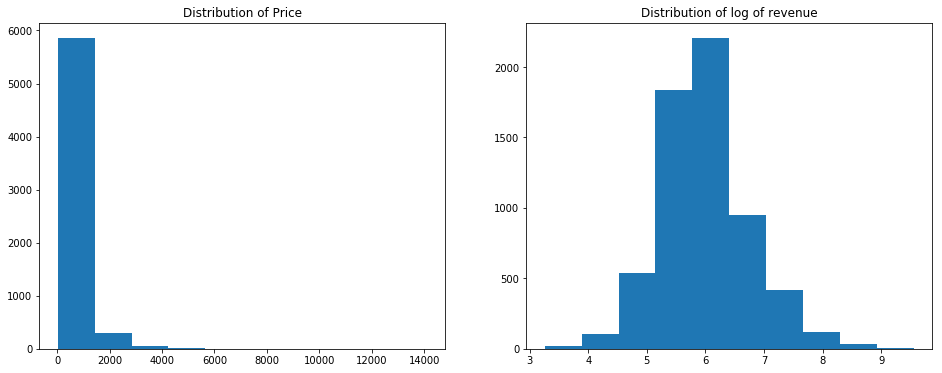

In [107]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['Price']);
plt.title('Distribution of Price');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['Price']));
plt.title('Distribution of log of revenue');

In [108]:
train_df['id'] = range(0, 0+len(train_df))
test_df['id'] = range(0, 0+len(test_df))

## Count features
for col in ['Author', 'BookCategory', 'Edition', 'Genre',  'Ratings',
          'Reviews',         
            ['Author', 'BookCategory'], 
            ['Author', 'Edition'], 
            ['Author', 'Genre'],
            ['Author', 'Ratings'],
            ['Author', 'Reviews'],
           

            
            

           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["id"]+ col], test_df[["id"]+ col]])
    gdf = all_df.groupby(col)["id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")

In [109]:
train_df['log_Price'] = np.log1p(train_df['Price'])
test_df['log_Price'] = np.log1p(test_df['Price'])

In [110]:
print(train_df.shape, test_df.shape)

(6237, 1128) (1560, 1128)


In [111]:
class renamer():
  def __init__(self):
    self.d = dict()

  def __call__(self, x):
    if x not in self.d:
      self.d[x] = 0
      return x
    else:
      self.d[x] += 1
      return "%s_%d" % (x, self.d[x])

In [112]:
train_df.rename(columns=renamer(), inplace=True)

In [113]:
test_df.rename(columns=renamer(), inplace=True)

In [114]:
print(train_df.shape, test_df.shape)

(6237, 1128) (1560, 1128)


In [115]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

In [116]:
cat_vars = ['Author', 'Genre', 'Ratings', 'Reviews', 'BookCategory', 'Edition_Type', 'Year', 'Month']
# getting mean encoding features
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'log_Price')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'log_Price')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

###  Model

In [117]:
train_X = train_df.drop(['is_train','Price', 'log_Price','Synopsis','Title', 'Date', 'Edition', 'BookCategory', 'Edition_Type',  'Month','id'],axis=1)
test_X = test_df.drop(['is_train', 'Price', 'log_Price', 'Synopsis', 'Title','Date', 'Edition','BookCategory', 'Edition_Type',  'Month', 'id'],axis=1)
y = (train_df['log_Price'])
train_y = y


X = train_X

In [118]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
    params = {}
    params["objective"] = "regression"
    params['metric'] = 'rmse'
    params["max_depth"] = 8
    params["min_data_in_leaf"] = 1
    params["learning_rate"] = 0.0025
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.8
    params["bagging_freq"] = 5
    params["bagging_seed"] = 0
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain,  num_rounds, valid_sets=[lgtest], 
                          early_stopping_rounds=200, verbose_eval=1000)
    else:
        lgtest = lgb.Dataset(test_X)
        model = lgb.train(params, lgtrain,   num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = np.sqrt(metrics.mean_squared_error(test_y, pred_test_y))
        print(loss)
        return pred_test_y, loss, pred_test_y2, model
    else:
        return pred_test_y, loss, pred_test_y2, model

In [119]:
cv_scores = []
pred_test_full = 0
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X, y):  
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_val, loss, pred_test,model = runLGB(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    cv_scores.append(loss)
    print(cv_scores)
pred_test_full /= 5.
print(sum(cv_scores)/5)

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.520673
[2000]	valid_0's rmse: 0.496192
[3000]	valid_0's rmse: 0.488982
[4000]	valid_0's rmse: 0.485267
[5000]	valid_0's rmse: 0.483064
[6000]	valid_0's rmse: 0.481801
[7000]	valid_0's rmse: 0.480791
[8000]	valid_0's rmse: 0.480082
[9000]	valid_0's rmse: 0.47954
[10000]	valid_0's rmse: 0.47909
[11000]	valid_0's rmse: 0.478765
[12000]	valid_0's rmse: 0.478467
[13000]	valid_0's rmse: 0.478206
Early stopping, best iteration is:
[13312]	valid_0's rmse: 0.478125
0.47812507361392914
[0.47812507361392914]
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.499831
[2000]	valid_0's rmse: 0.477791
[3000]	valid_0's rmse: 0.471628
[4000]	valid_0's rmse: 0.468586
[5000]	valid_0's rmse: 0.466549
[6000]	valid_0's rmse: 0.465412
[7000]	valid_0's rmse: 0.464683
[8000]	valid_0's rmse: 0.464205
[9000]	valid_0's rmse: 0.463778
Early stopping, best iteration is:
[9488]	valid_0's rmse: 

In [123]:
# # Fill the is_pass variable with the predictions
sub_df['Price']= pd.DataFrame(np.exp(pred_test_full))

# # Converting the submission file to excel format
sub_df.to_excel('lgb_101_bs_0_lr_0p0025_final_2.xlsx', index=False)